In [ ]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

In [2]:
import librosa
import librosa.display as ds
import IPython.display as ipd
import pandas as pd
import numpy as np
import tensorflow as tf
import json
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
#pip install -U keras-tuner


<h2>Find the best parameters

In [ ]:
from kerastuner import HyperModel
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = tf.keras.Sequential()

        model.add(tf.keras.layers.Flatten(input_shape=self.input_shape))

        model.add(
            tf.keras.layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu'
            ))
        
        model.add(
            tf.keras.layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu'
            ))
        
        model.add(
           tf.keras.layers.Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
        model.add(
            tf.keras.layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                            activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            ))
        
        model.add(
            tf.keras.layers.Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
      
        model.add(tf.keras.layers.Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model



In [ ]:
from kerastuner.tuners import RandomSearch

NUM_CLASSES = 75  # cifar10 number of classes
INPUT_SHAPE = (X_train.shape[1],1)  # cifar10 images input shape

hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=1,
    max_trials=20,
    executions_per_trial=2,
    directory='random_search',
    project_name='Speaker'
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(X_train, y_train,
             epochs=80,
            validation_data=(X_validation, y_validation))

In [ ]:
tuner.results_summary()

In [ ]:
models = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
loss, accuracy = best_model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 4ms/step - loss: 0.1552 - accuracy: 0.9589


In [ ]:
best_model.save('/content/drive/My Drive/Saved model SR/NN MFCC /my_model_NN_MFCC_darija_bestmodel95_89.h5')

<h2>Load the prepared data

In [ ]:
dataset = "C:/Users/zenno/Downloads/50_speakers_audio_data/"
json_path = "/content/drive/My Drive/Sentiment Analysis/Speaker Recognition PFE/json_data_mffcs_darija5.json"

In [ ]:
def features_target(json_path):

    with open(json_path, "r") as jp:
        data = json.load(jp)

    X = np.array(data["MFCC"])

    y = np.array(data["speaker_labels"])

    return X, y

In [ ]:
X,y=features_target(json_path)
print(X.shape)
y.shape

(4215, 20)


(4215,)

In [ ]:
def split_dataset(json_path, test_size=0.15,validation_size=0.15):

    X, y = features_target (json_path)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    return X_train, y_train,X_validation,y_validation,X_test, y_test

In [ ]:
X_train,y_train,X_validation,y_validation,X_test,y_test=split_dataset(json_path)
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)
X_train.ndim
#X_normalized = preprocessing.normalize(X_train[2], norm='l2')

(3044, 20, 1)
(538, 20, 1)
(633, 20, 1)


3

<h2>Build the model and train it

In [ ]:
def plot_the_accuracy_curve(epochs, accuracy,val_accuracy):
  """Plot a curve of loss vs. epoch."""

  plt.figure(figsize=(15, 5))
  plt.xlabel("Epoch")
  plt.ylabel("accuracy")

  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.legend()
  #plt.ylim([accuracy.min()*0.97, accuracy.max()])
  plt.show()  

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


In [ ]:
def plot_the_loss_curve(epochs, loss,val_loss):
  """Plot a curve of loss vs. epoch."""

  plt.figure(figsize=(15, 5))
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.legend()
  #plt.ylim([accuracy.min()*0.97, accuracy.max()])
  plt.show()  

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


In [ ]:
def build_model(learning_rate,input_shape):
  
   model = tf.keras.Sequential()

   # input layer
   model.add(tf.keras.layers.Flatten(input_shape=input_shape))

   # 1st dense layer
   model.add(tf.keras.layers.Dense(384, activation='relu'))
   
   # 2nd dense layer
   model.add(tf.keras.layers.Dense(384, activation='relu'))
   model.add(tf.keras.layers.Dropout(0.30000000000000004))

   # 3rd dense layer
   model.add(tf.keras.layers.Dense(384, activation='relu'))
   model.add(tf.keras.layers.Dropout( 0.25))

   # output layer
   model.add(tf.keras.layers.Dense(75, activation='softmax'))
   
   # compile model
   optimiser = tf.keras.optimizers.Adam(learning_rate)
   model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

   model.summary()

   return model

In [ ]:
def train_model(model,X_train,y_train,X_validation,y_validation,batch_size=32,epochs=100):
  
   earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=8)
    # train model
   model_trained = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), 
                             batch_size=batch_size, epochs=epochs,  callbacks=[earlystop_callback])                
   trained_weight = model.get_weights()[0]
   trained_bias = model.get_weights()[1]
   epochs = model_trained.epoch
   hist = pd.DataFrame(model_trained.history)

  # To track the progression of training, 
   accuracy=hist["accuracy"]
   val_accuracy=hist["val_accuracy"]
   loss=hist["loss"]
   val_loss=hist["val_loss"]
   return  epochs,accuracy,val_accuracy,loss,val_loss

In [ ]:
input_shape=(X_train.shape[1],1)
model=build_model( 0.0011971901340926848,input_shape)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 384)               8064      
_________________________________________________________________
dense_9 (Dense)              (None, 384)               147840    
_________________________________________________________________
dropout_3 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 384)               147840    
_________________________________________________________________
dropout_4 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 75)               

In [ ]:
epochs,accuracy,val_accuracy,loss,val_loss=train_model(model,X_train,y_train,X_validation,y_validation)

Epoch 1/100
96/96 [==============================] - 1s 6ms/step - loss: 4.2755 - accuracy: 0.0338 - val_loss: 4.0229 - val_accuracy: 0.0465
Epoch 2/100
96/96 [==============================] - 0s 5ms/step - loss: 3.4357 - accuracy: 0.1045 - val_loss: 2.9263 - val_accuracy: 0.1338
Epoch 3/100
96/96 [==============================] - 0s 4ms/step - loss: 2.7579 - accuracy: 0.2181 - val_loss: 2.1028 - val_accuracy: 0.4312
Epoch 4/100
96/96 [==============================] - 0s 5ms/step - loss: 2.0901 - accuracy: 0.3850 - val_loss: 1.6068 - val_accuracy: 0.5260
Epoch 5/100
96/96 [==============================] - 0s 4ms/step - loss: 1.6307 - accuracy: 0.5131 - val_loss: 1.1957 - val_accuracy: 0.6654
Epoch 6/100
96/96 [==============================] - 0s 5ms/step - loss: 1.3007 - accuracy: 0.6015 - val_loss: 0.8368 - val_accuracy: 0.7788
Epoch 7/100
96/96 [==============================] - 0s 5ms/step - loss: 1.0634 - accuracy: 0.6741 - val_loss: 0.8052 - val_accuracy: 0.7937
Epoch 8/100
9

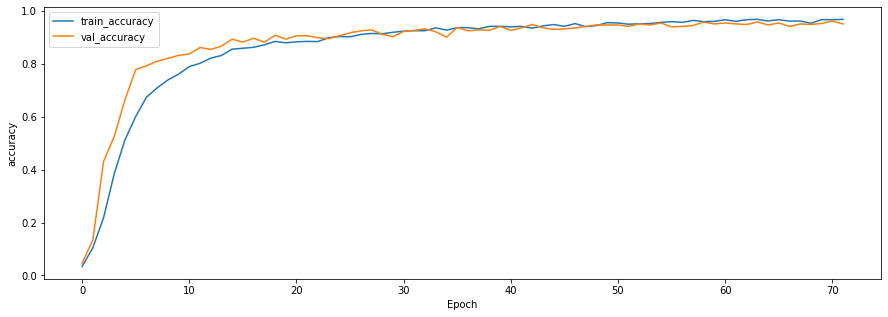

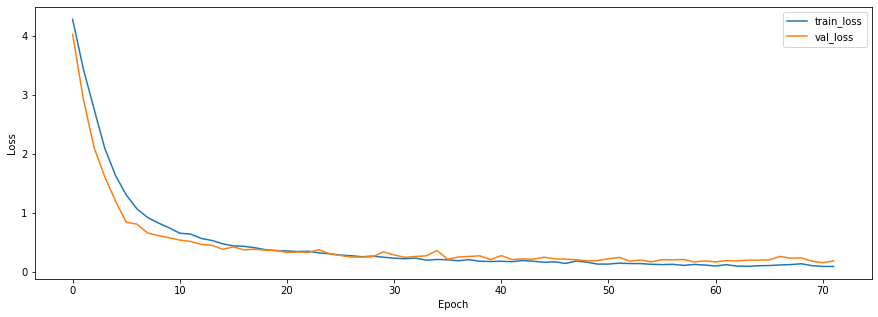

In [ ]:
#plot the metrics
plot_the_accuracy_curve(epochs, accuracy,val_accuracy)
plot_the_loss_curve(epochs, loss,val_loss)

In [ ]:
loss,accuracy=model.evaluate(X_test,y_test)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

20/20 [==============================] - 0s 3ms/step - loss: 0.1254 - accuracy: 0.9621
Loss: 0.1254
Accuracy: 96.21%


In [ ]:
model.save('/content/drive/My Drive/Saved model SR/NN MFCC /my_model_NN_MFCC_darija_96_21.h5')

<h1>Test Level

In [ ]:
def pre_emphasis(signal,pre_emphasis=0.97):
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    return emphasized_signal

In [ ]:
def framing(signal,sample_rate=16000,frame_size=0.025,step_size=0.010):
        frame_length = int(np.floor(frame_size * sample_rate))
        frame_shift = int(np.floor(step_size * sample_rate))
        signal_length=len(signal)
        hamwin = np.hamming(frame_length)
        num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_shift))
        frames = np.zeros([frame_length, num_frames])
        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_shift, frame_shift), (frame_length, 1)).T
        frames=signal[indices]    
        frames = frames*hamwin
        return frames

In [ ]:
def deframing(frames,sample_rate=16000,frame_size=0.025,step_size=0.010):
        frame_length = int(np.floor(frame_size * sample_rate))
        frame_shift = int(np.floor(step_size * sample_rate))
        hamwin = np.hamming(frame_length)
        num_frames=frames.shape[0]
        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_shift, frame_shift), (frame_length, 1)).T
        padlen = (num_frames - 1) * frame_shift + frame_length
        nwsignal=np.zeros(padlen)
        remv_win=np.zeros(padlen)
        e=0.0000001
        for i in range(num_frames):
          remv_win[indices[i,:]]=remv_win[indices[i,:]]+hamwin+e
          nwsignal[indices[i,:]]=nwsignal[indices[i,:]]+frames[i,:]
        nwsignal=nwsignal/remv_win
        return nwsignal

In [ ]:
def Zero_crossing_rate(frame):                           
      zr = 0
      for k in range(1, len(frame)):
            if (0.5*abs(np.sign(frame[k]) - np.sign(frame[k - 1])))==1:
                zr+=1
      return zr/len(frame)

In [ ]:
def short_time_Energy(frames):
    return sum( [abs(x)**2 for x in frames] ) 

In [ ]:
def VAD(signal,sample_rate):
    frames=framing(signal,sample_rate)
    frame_size=0.025
    win_size = int(np.floor(frame_size * sample_rate))
    framess=np.array([])
    index=[]
    for i,f in enumerate(frames):
        if (short_time_Energy(f)<0.05 and Zero_crossing_rate(f)>0.4):
            index.append(i)
    framess=np.delete(frames,index,0)
    new_signal=deframing(framess)
    return new_signal

In [ ]:
def get_MFCC(signal, sample_rate=16000,duration=60):
  
    sample=int((sample_rate*duration)/3)
    if len(signal) >= sample:
         signal = signal[:sample]
    mfcc = librosa.feature.mfcc(signal, sr=sample_rate,n_mfcc=20,hop_length=int(0.010 *sample_rate), n_fft = int(0.025 * sample_rate))
    print(mfcc.shape)
    #delta_mfcc=librosa.feature.delta(mfcc,order=1)
    mfcc_features= np.mean(mfcc,1)
    mfcc_features= (mfcc_features-np.mean(mfcc_features))/np.std(mfcc_features)
    
    return mfcc_features.T

In [ ]:
def pre(file,sample_rate):
    
    signal, sample_rate = librosa.load(file,sr=sample_rate)

                    #normalise the signal
    #signal=signal/np.max(signal)
                    
                    #Pre_emphasis
    signal=pre_emphasis(signal)

                    #VAD
    signal=VAD(signal,sample_rate)

                    # extract MFCC
    mfcc=get_MFCC(signal)
         
                    
    return mfcc

In [ ]:
predict_iterator =model.predict(X_test)


predicted_labels = []

for pred in predict_iterator:
    predicted_labels += np.argmax(pred).flatten().tolist()

print('Predicted labels:', predicted_labels[:10], 'True labels:', y_test[:10].tolist())

Predicted labels: [42, 42, 50, 62, 69, 9, 24, 58, 20, 15] True labels: [42, 42, 50, 62, 69, 9, 24, 58, 20, 15]


In [ ]:
NN_model =  tf.keras.models.load_model('/content/drive/My Drive/Saved model SR/NN MFCC /my_model_NN_MFCC_darija_bestmodel95_89.h5')
#NN_model.summary()
NN_model.get_weights()
#NN_model.evaluate(X_test,y_test)

In [ ]:
file1="/content/drive/My Drive/Colab Notebooks/mix_27s (audio-joiner.com).wav"
file47="/content/drive/My Drive/Colab Notebooks/mix_10s (audio-joiner.com).wav"
unknow_speaker_1=pre(file1,16000)
unknow_speaker_47=pre(file47,16000)

(20, 2001)
(20, 971)


In [ ]:
speaker1=np.array(unknow_speaker_1)

speaker47=np.array(unknow_speaker_47)

print(speaker1.shape)

speaker1 = speaker1[np.newaxis,...]

#speaker1 = speaker1[...,np.newaxis]

speaker47 = speaker47[np.newaxis,...]

#speaker47 = speaker47[...,np.newaxis]

speaker1.shape

(20,)


(1, 20)

In [ ]:
prded=model.predict([speaker1])

prd=np.argmax(prded)
with open(json_path, "r") as jp:
        data = json.load(jp)
speakers=data["speakers"]
print("the speaker predicted by our model is: Speaker {} avec une certainité de {} %".format(speakers[prd],np.max(prded)*100))

prded

the speaker predicted by our model is: Speaker Elamri Yassine avec une certainité de 85.38692593574524 %


array([[4.97309642e-08, 2.58313436e-02, 2.87045249e-10, 3.24194588e-10,
        2.01267940e-05, 4.49757592e-12, 2.28060131e-07, 6.24287507e-15,
        2.11990752e-07, 1.37192602e-09, 2.91721551e-12, 8.15136730e-07,
        2.92515596e-19, 2.13729940e-08, 1.14615310e-10, 3.13494647e-10,
        2.36365867e-16, 3.99540255e-07, 4.30860521e-11, 1.67769772e-15,
        5.26832301e-14, 7.30844066e-11, 2.56765417e-14, 2.08214542e-16,
        4.12909649e-05, 1.14953091e-05, 4.05686620e-07, 8.53869259e-01,
        3.72470321e-09, 4.75839647e-15, 6.02965997e-08, 1.66659484e-05,
        3.82674509e-03, 1.16037786e-01, 4.82156632e-21, 6.02054968e-07,
        6.65605025e-18, 1.59057578e-09, 6.63114103e-17, 1.94794602e-15,
        8.51520740e-16, 2.22287115e-20, 2.54998458e-08, 3.56122870e-20,
        2.82152366e-17, 5.25201125e-17, 3.97039381e-11, 1.28456190e-09,
        1.75254993e-12, 3.96118104e-11, 2.34290898e-08, 9.54611095e-17,
        6.70745067e-06, 2.21100563e-13, 3.30076140e-16, 7.535759

In [ ]:
prd=model.predict([speaker47])

ar=prd.flatten()
print(ar)
indx=ar.argsort()[-4:][::-1]

with open(json_path, "r") as jp:
        data = json.load(jp)

speakers=data["speakers"]
print(ar[70])
print("the speakers Talking in this conversation are :  {} , {} and {} and {}".format(speakers[indx[0]],speakers[indx[1]],speakers[indx[2]],speakers[indx[3]]))
print("proba {}, {}, {} and {}".format(ar[indx[0]]*100,ar[indx[1]]*100,ar[indx[2]]*100,ar[indx[3]]*100))

[3.70193050e-08 2.64103319e-02 6.09996754e-13 4.88651957e-12
 1.52686290e-08 4.14833203e-11 6.04044637e-09 3.07029708e-15
 1.97153508e-06 6.49594378e-10 1.10555107e-10 1.17466833e-07
 1.05534404e-19 6.66583233e-08 8.71617015e-11 4.27735597e-10
 6.46559697e-14 2.29018298e-08 3.24551753e-14 3.22803039e-16
 7.74568061e-16 2.53922855e-10 5.92397691e-16 1.19615531e-16
 6.21583895e-04 4.15595772e-04 6.70750239e-07 2.48926394e-02
 4.59120963e-10 5.33376674e-13 5.86791145e-07 4.47514367e-06
 9.46634352e-01 2.99388950e-04 2.39965863e-21 6.70553879e-09
 4.11101978e-15 8.24196126e-13 2.18302837e-16 9.95321515e-14
 5.50321236e-14 2.40001802e-19 2.14884596e-10 9.25963943e-20
 1.43011339e-18 3.28962821e-15 5.97181809e-12 2.49437335e-07
 2.38261711e-12 3.25221967e-12 1.40375107e-06 1.60153582e-17
 5.25818141e-05 9.81741933e-15 8.52668681e-16 2.49911758e-10
 6.31481991e-04 2.14028910e-06 4.77917228e-12 1.03012530e-14
 3.83714891e-12 1.83363168e-14 8.71454926e-13 1.48383629e-17
 1.32490321e-11 1.356818